# Process scRNA-seq data to the input of TFcomb

In this notebook, we process scRNA-seq data from the raw count. We normalized the scRNA-seq data and add important TFs.

## import

In [1]:
import sys 
import os
import importlib
sys.path.append("/data1/lichen/code/ECA2.0/drug_experiment/code/ISDE_GRN/GRN_benchmark/CellOracle_benchmark/CellOracle_based_function/")

from utility.utility import intersect
from trajectory.oracle_utility import _is_perturb_condition_valid
from trajectory.oracle_utility import _adata_to_df

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import celloracle as co
co.__version__
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/data1/lichen/anaconda3/envs/dgl/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/data1/lichen/anaconda3/envs/dgl/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/data1/lichen/anac

In [28]:
sys.path.append("/data1/lichen/code/cell_state_control/scControl/v1")
import utils
from utils import *

In [27]:
importlib.reload(utils)

<module 'utils' from '/data1/lichen/code/cell_state_control/scControl/v1/utils.py'>

## Load raw count matrix of scRNA-seq data

In [5]:
data_dir = '/nfs/public/lichen/data/single_cell/reprogramming_case/fib_ipsc/RNA/'
adata_anno = sc.read(os.path.join(data_dir,'adata_anno.h5ad'))
adata_anno

AnnData object with n_obs × n_vars = 8617 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'CellLineSOUPorCELL', 'percent.mt', 'SampleName', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'CellTypeLR', 'celltype'
    var: 'Unnamed: 0'

In [36]:
filter_tforf_list = ['POU5F1',
                 'NANOG',
                 'SOX2',
                 'KLF4',
                 'MYC',
                'LIN28A'
                 ]

## Get added TF list

In [29]:
cluster_name_for_GRN_unit = 'celltype'
init_cluster = 'Fibroblasts'
control_cluster = 'iPSCs'
base_GRN_dir = os.path.join('/nfs/public/lichen/results/ISDE_GRN/reprogramming_case/','fib_ipsc',"base_GRN_dataframe_stream.parquet")
add_TF_list = select_add_TF(adata_anno, cluster_name_for_GRN_unit, init_cluster, control_cluster, base_GRN_dir = base_GRN_dir, subset = True)

group_hvg: tf in adata is: 744
group_marker_gene: tf in adata is: 754
group_highexp_gene: tf in adata is: 754
add_TF_list length is: 24


## debug

### highly variable genes

In [20]:
filter_tforf_list = ['POU5F1',
                 'NANOG',
                 'SOX2',
                 'KLF4',
                 'MYC',
                'LIN28A'
                 ]

In [22]:
adata = adata_anno.copy()
adata.var_names_make_unique()

cluster_name_for_GRN_unit = 'celltype'
filter_tforf_list = ['POU5F1',
                 'NANOG',
                 'SOX2',
                 'KLF4',
                 'MYC',
                    'LIN28A'
                 ]
init_cluster = 'Fibroblasts'
control_cluster = 'iPSCs'


group = control_cluster
adata = adata[adata.obs[cluster_name_for_GRN_unit].isin([init_cluster, control_cluster])].copy()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

min_mean       =0.0125
max_mean       =3
min_disp       =0.5
n_neighbors    =10
n_pcs          =30

# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
adata_raw = adata.copy()

sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
# sc.pp.highly_variable_genes(adata,n_top_genes=2000)

# df = adata.var.highly_variable
# df = df[df==True]
# gene_list = list(df.index)

# adata = adata[:, adata.var.highly_variable]
# adata
df = sc.pp.highly_variable_genes(adata,n_top_genes=15000,inplace=False)
df = df.sort_values(by='dispersions_norm',ascending=False)
idx_list = list(df[df.highly_variable==True].index)

In [23]:
gene_list = list(adata[:, idx_list].var_names)

print(f'filter genes are: {len(gene_list)}')
print(filter_tforf_list)
print([i in gene_list for i in filter_tforf_list])

base_GRN = pd.read_parquet(os.path.join('/nfs/public/lichen/results/ISDE_GRN/reprogramming_case/','fib_ipsc',"base_GRN_dataframe_stream.parquet"))
print(f"the base_GRN shape is {base_GRN.shape}")

TFdict = import_TF_data(TF_info_matrix=base_GRN)

tf_target_dict = {}
for target, gene_set in TFdict.items():
    for tf in gene_set:
        if tf not in tf_target_dict:
            tf_target_dict[tf] = []
            tf_target_dict[tf].append(target)
        else:
            tf_target_dict[tf].append(target)
total_tf_list = list(tf_target_dict.keys())
print(f'tf in baseGRN is: {len(total_tf_list)}')

adata_tf_list2 = [i for i in gene_list if i in total_tf_list]
print(f'tf in adata is: {len(adata_tf_list2)}')

for tf in filter_tforf_list:
    if tf not in adata_tf_list2:
        print(f'{tf} not in')
        continue
    print(f'{tf} index is: {adata_tf_list2.index(tf)}')

filter genes are: 15000
['POU5F1', 'NANOG', 'SOX2', 'KLF4', 'MYC', 'LIN28A']
[True, True, True, False, True, True]
the base_GRN shape is (31844, 1100)
tf in baseGRN is: 1098
tf in adata is: 568
POU5F1 index is: 64
NANOG index is: 180
SOX2 index is: 61
KLF4 not in
MYC index is: 266
LIN28A not in


### marker genes

In [24]:
adata = adata_anno.copy()
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=20000)
# adata = adata[:, adata.var.highly_variable]
adata.raw = adata

cluster_name_for_GRN_unit = 'celltype'

filter_tforf_list = ['POU5F1',
                 'NANOG',
                 'SOX2',
                 'KLF4',
                 'MYC',
                    'LIN28A'
                 ]
init_cluster = 'Fibroblasts'
control_cluster = 'iPSCs'


group = control_cluster
adata_part = adata[adata.obs[cluster_name_for_GRN_unit].isin([init_cluster, control_cluster])]
sc.tl.rank_genes_groups(adata=adata_part, groupby = cluster_name_for_GRN_unit,groups=[group], reference='rest', method='wilcoxon')
# p_val = 5e-2
# idx=np.where(adata_part.uns['rank_genes_groups']['pvals_adj'][group]>p_val)[0][0]
idx = len(adata_part.uns['rank_genes_groups']['names'][group])
# idx = 3000
gene_list = adata_part.uns['rank_genes_groups']['names'][group][0:idx]

print(f'filter genes are: {len(gene_list)}')
print(filter_tforf_list)
print([i in gene_list for i in filter_tforf_list])

base_GRN = pd.read_parquet(os.path.join('/nfs/public/lichen/results/ISDE_GRN/reprogramming_case/','fib_ipsc',"base_GRN_dataframe_stream.parquet"))
print(f"the base_GRN shape is {base_GRN.shape}")

TFdict = import_TF_data(TF_info_matrix=base_GRN)

tf_target_dict = {}
for target, gene_set in TFdict.items():
    for tf in gene_set:
        if tf not in tf_target_dict:
            tf_target_dict[tf] = []
            tf_target_dict[tf].append(target)
        else:
            tf_target_dict[tf].append(target)
total_tf_list = list(tf_target_dict.keys())
print(f'tf in baseGRN is: {len(total_tf_list)}')

adata_tf_list3 = [i for i in gene_list if i in total_tf_list]
print(f'tf in adata is: {len(adata_tf_list3)}')

for tf in filter_tforf_list:
    if tf not in adata_tf_list3:
        print(f'{tf} not in')
        continue
    print(f'{tf} index is: {adata_tf_list3.index(tf)}')

filter genes are: 33538
['POU5F1', 'NANOG', 'SOX2', 'KLF4', 'MYC', 'LIN28A']
[True, True, True, True, True, True]
the base_GRN shape is (31844, 1100)
tf in baseGRN is: 1098
tf in adata is: 874
POU5F1 index is: 0
NANOG index is: 5
SOX2 index is: 3
KLF4 index is: 187
MYC index is: 30
LIN28A not in


### expression

In [25]:
adata = adata_anno.copy()
adata.var_names_make_unique()

cluster_name_for_GRN_unit = 'celltype'

filter_tforf_list = ['POU5F1',
                 'NANOG',
                 'SOX2',
                 'KLF4',
                 'MYC',
                    'LIN28A'
                 ]

init_cluster = 'Fibroblasts'
control_cluster = 'iPSCs'

group = control_cluster
adata = adata[adata.obs[cluster_name_for_GRN_unit].isin([control_cluster])].copy()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

min_mean       =0.0125
max_mean       =3
min_disp       =0.5
n_neighbors    =10
n_pcs          =30

# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
adata_raw = adata.copy()

sc.pp.log1p(adata)

df = pd.DataFrame({'gene':adata.var_names,
                   'score':np.array(np.mean(adata.X,axis=0)).ravel()})
df = df.sort_values(by='score', ascending=False)
gene_list = list(df.iloc[0:10000,:].gene)

print(f'filter genes are: {len(gene_list)}')
print(filter_tforf_list)
print([i in gene_list for i in filter_tforf_list])

base_GRN = pd.read_parquet(os.path.join('/nfs/public/lichen/results/ISDE_GRN/reprogramming_case/','fib_ipsc',"base_GRN_dataframe_stream.parquet"))
print(f"the base_GRN shape is {base_GRN.shape}")

TFdict = import_TF_data(TF_info_matrix=base_GRN)

tf_target_dict = {}
for target, gene_set in TFdict.items():
    for tf in gene_set:
        if tf not in tf_target_dict:
            tf_target_dict[tf] = []
            tf_target_dict[tf].append(target)
        else:
            tf_target_dict[tf].append(target)
total_tf_list = list(tf_target_dict.keys())
print(f'tf in baseGRN is: {len(total_tf_list)}')

adata_tf_list4 = [i for i in gene_list if i in total_tf_list]
print(f'tf in adata is: {len(adata_tf_list4)}')

for tf in filter_tforf_list:
    if tf not in adata_tf_list4:
        print(f'{tf} not in')
        continue
    print(f'{tf} index is: {adata_tf_list4.index(tf)}')

filter genes are: 10000
['POU5F1', 'NANOG', 'SOX2', 'KLF4', 'MYC', 'LIN28A']
[True, True, True, True, True, True]
the base_GRN shape is (31844, 1100)
tf in baseGRN is: 1098
tf in adata is: 374
POU5F1 index is: 1
NANOG index is: 16
SOX2 index is: 6
KLF4 index is: 296
MYC index is: 47
LIN28A not in


In [26]:
tmp_list = np.intersect1d(np.intersect1d(adata_tf_list3[0:100],adata_tf_list4[0:100]),adata_tf_list2[0:400])
# tmp_list = np.intersect1d(adata_tf_list3[0:300],adata_tf_list4[0:300])
len(tmp_list), [i in tmp_list for i in filter_tforf_list],sorted(tmp_list)

(24,
 [True, True, True, False, True, False],
 ['ATF4',
  'CREB1',
  'ETV4',
  'FOXH1',
  'FOXN3',
  'HMGA1',
  'HMGA2',
  'HMGN3',
  'ID1',
  'ID3',
  'MYC',
  'NANOG',
  'NR6A1',
  'POLR3G',
  'POU5F1',
  'RBPJ',
  'SOX11',
  'SOX2',
  'SOX4',
  'STAT3',
  'TGIF1',
  'USF2',
  'YBX1',
  'ZFP42'])

## Filter scRNA data

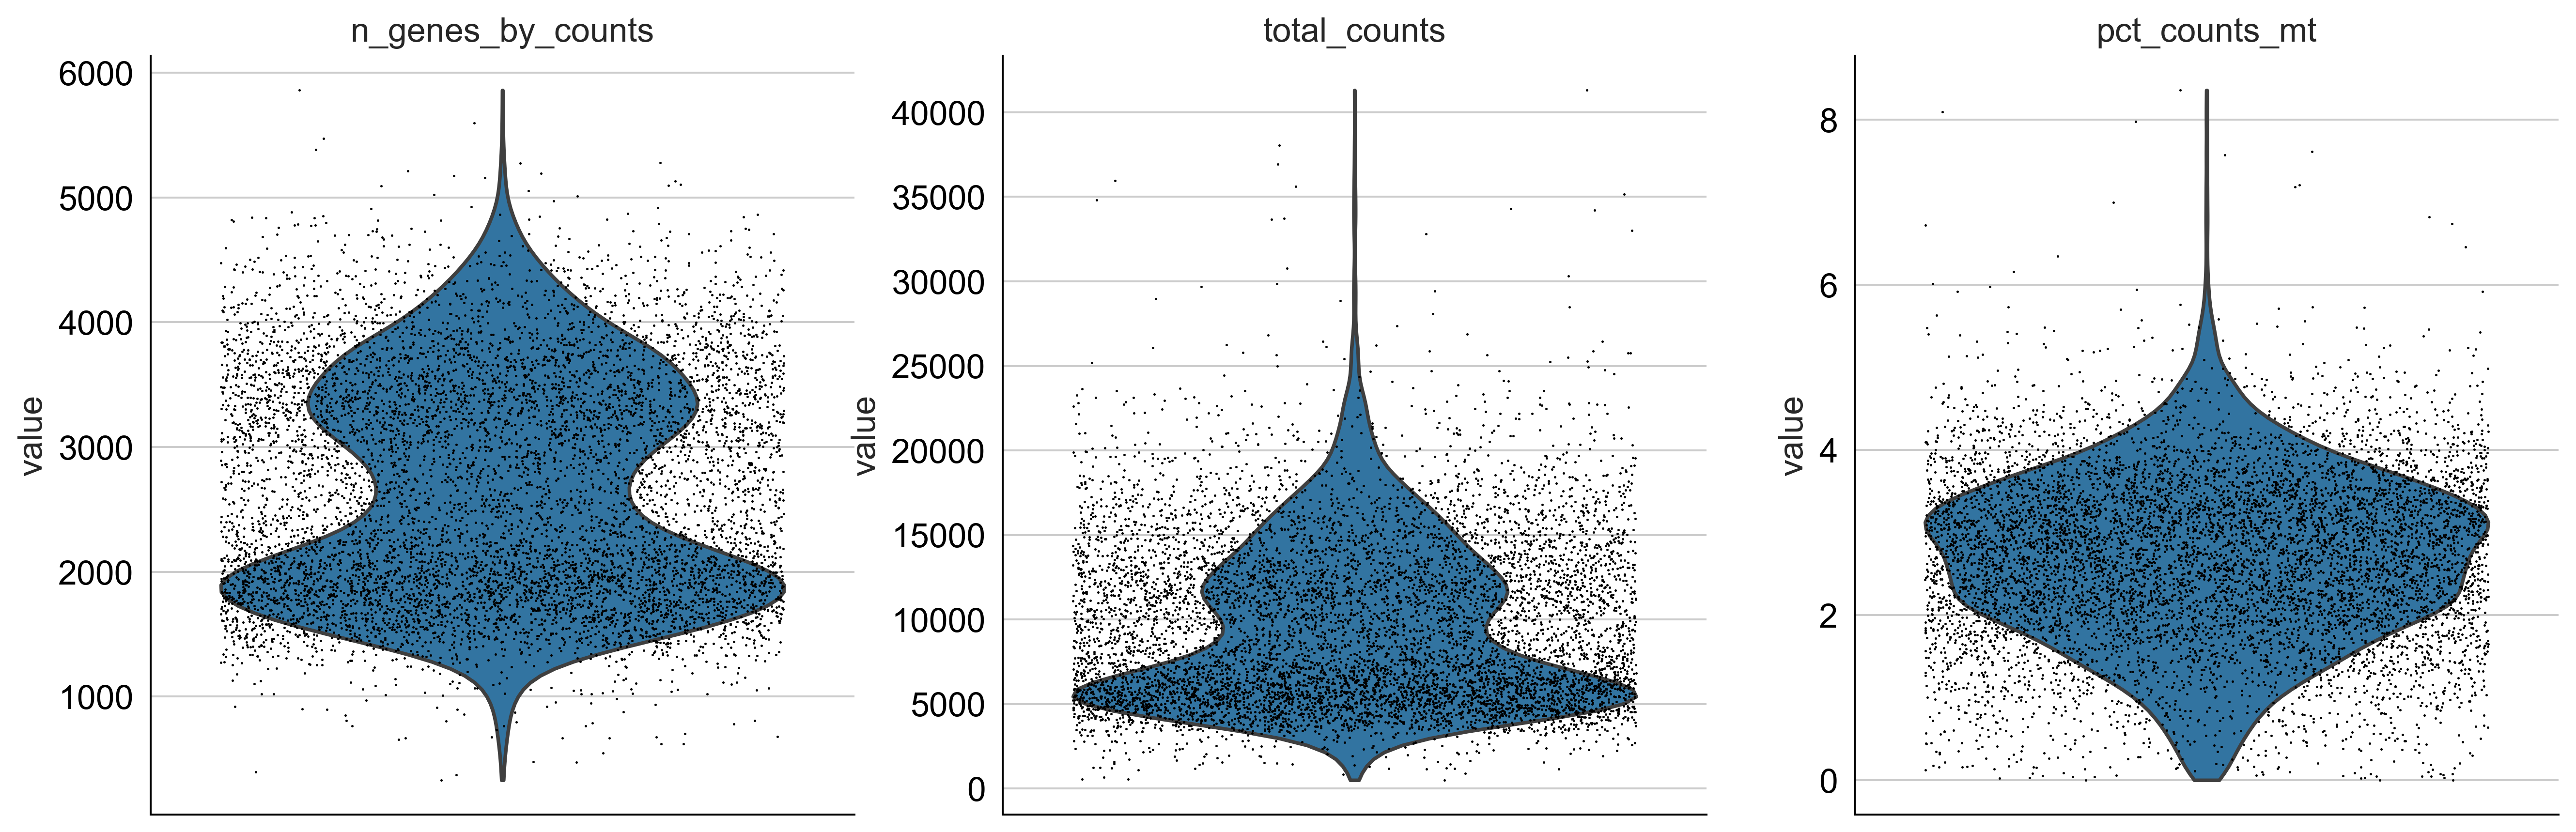

View of AnnData object with n_obs × n_vars = 7841 × 20091
    obs: 'nCount_RNA', 'nFeature_RNA', 'CellLineSOUPorCELL', 'percent.mt', 'SampleName', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'CellTypeLR', 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Unnamed: 0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [31]:

adata = adata_anno.copy()
adata.var_names_make_unique()


adata = adata[adata.obs[cluster_name_for_GRN_unit].isin([init_cluster, control_cluster])].copy()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

adata = adata[adata.obs.pct_counts_mt < 6, :]

adata

## Plot UMAP

In [32]:
min_mean       =0.0125
max_mean       =3
min_disp       =0.8
n_neighbors    =10
n_pcs          =30

# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
adata_raw = adata.copy()

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)


# for tf in filter_tforf_list:
#     adata.var.highly_variable[tf] = True
    
for tf in add_TF_list:
    adata.var.highly_variable[tf] = True
    

adata = adata_raw[:, adata.var.highly_variable]
# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

# keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)


# pca
sc.tl.pca(adata, svd_solver='arpack',random_state=2022)
# neighbors
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs,random_state=2022)
sc.settings.set_figure_params(dpi=180, facecolor='white')
# check umap
sc.tl.umap(adata,random_state=2022)

In [33]:
adata

AnnData object with n_obs × n_vars = 7841 × 1838
    obs: 'nCount_RNA', 'nFeature_RNA', 'CellLineSOUPorCELL', 'percent.mt', 'SampleName', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'CellTypeLR', 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts_all', 'n_counts'
    var: 'Unnamed: 0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [38]:
tmp_filter_tforf_list = [i for i in filter_tforf_list if i in adata.var_names]

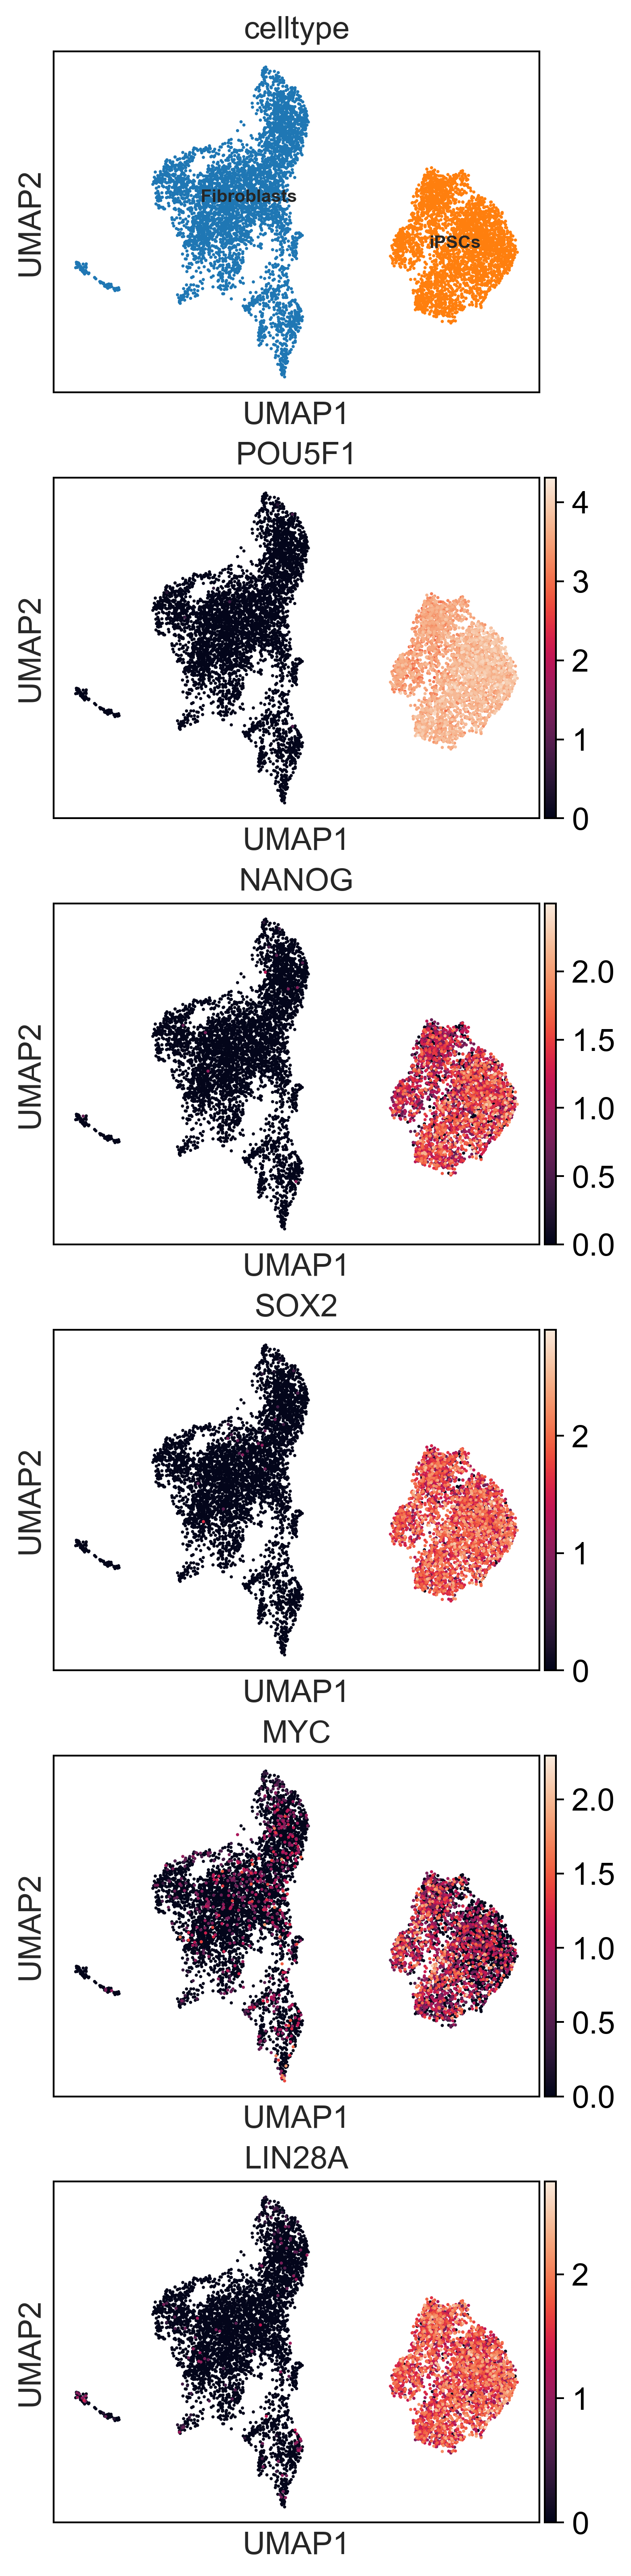

In [39]:
point_size = 8
sc.settings.set_figure_params(dpi=180, facecolor='white')
plt.rcParams["figure.figsize"] = [3, 3]
sc.pl.umap(adata, color=['celltype'] + tmp_filter_tforf_list,size=point_size,legend_fontsize=8,
           ncols=1, wspace=0.4,legend_loc='on data')